## Approach validation

This notebook serves as collection of the results for each taken approach over 2 datasets - Vesta and Elliptic.

In [3]:
from src import random_forest as rf
from src import preprocessing_vesta as pv
from src import graph_vesta as gv
from src import preprocessing_elliptic as pe
from importlib import reload

2022-07-03 11:24:52 Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-07-03 11:24:52 NumExpr defaulting to 8 threads.


In [56]:
import pandas as pd
import numpy as np
import pickle
import random
import sys
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import os

## 1. Vesta, without graph features, PCA (continuous features) + label encoded categorical features
### 1.1 Creating train set

In [38]:
vesta_pca = pd.read_pickle("../data/interim/vesta_train_pca.pkl")
vesta_enc = pd.read_pickle("../data/interim/vesta_encoded.pkl")
vesta_cat_vars = pd.read_pickle("../data/interim/categorical_features.pkl")
if "isFraud" in vesta_cat_vars:
    vesta_cat_vars.remove("isFraud")
with open("../data/processed/vesta_pca_enc.pkl", "wb") as handle:
    pickle.dump(
        np.hstack((vesta_pca, vesta_pca, vesta_enc[vesta_cat_vars])), handle, protocol=pickle.HIGHEST_PROTOCOL
    )

### 1.2 Running the model

In [12]:
reload(rf)
rfv = rf.RF(n_jobs=8)
rfv.load_data(dataset_final_pattern="vesta_pca_enc")

0

In [13]:
rfv_scores = {
    "test_accuracy": [], "test_precision": [], "test_recall": [], "test_f1_score": []
}
random.seed(2022)
seeds = [random.randint(0, 2**32-1) for x in range(1)]

for s in tqdm(seeds):
    curr_score = rfv.cv_base_model(
        verbose=2, name_prefix="vesta_pca_enc_rf_", print_val_scoring=False, return_scoring=True, seed=s
    )
    for k,v in curr_score.items():
        # print(k, np.mean(v))
        rfv_scores[k].append(np.mean(v))

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


test_accuracy 0.9524542378011683
test_precision 0.9203643345909808
test_recall 0.4314362400660682
test_f1_score 0.5872885024071043


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 14.2min finished


## 2. Approach (1) with graph features

In [47]:
with open("../data/processed/vesta_graph_train_0.pkl", "rb") as handle:
    vesta_graph_features = pickle.load(handle)
all_features = list(vesta_graph_features.columns)
graph_features = list(filter(re.compile(r".*degree.*|.*pagerank.*|.*hits.*|.*betweenness.*|.*wcc.*|.*community.*").match, all_features))
vesta_graph_features = vesta_graph_features[graph_features]
print(f"Added {len(graph_features)} graph features to the PCA (continuous) + Label encoded (categorical) dataset")
with open("../data/processed/vesta_pca_enc.pkl", "rb") as handle:
    vesta_pca_enc = pickle.load(handle)
vesta_pca_enc_graph = pd.concat((pd.DataFrame(vesta_pca_enc), vesta_graph_features), axis=1)
del vesta_graph_features, vesta_pca_enc
with open("../data/processed/vesta_pca_enc_graph.pkl", "wb") as handle:
    pickle.dump(vesta_pca_enc_graph, handle, protocol=pickle.HIGHEST_PROTOCOL)

Added 14 graph features to the PCA (continuous) + Label encoded (categorical) dataset


### 2.2 Running the model

In [49]:
reload(rf)
rfv2 = rf.RF(n_jobs=10)
rfv2.load_data(dataset_final_pattern="vesta_pca_enc_graph")

0

In [51]:
rfv2_scores = {
    "test_accuracy": [], "test_precision": [], "test_recall": [], "test_f1_score": []
}
random.seed(2022)
seeds = [random.randint(0, 2**32-1) for x in range(1)]

for s in tqdm(seeds):
    curr_score = rfv2.cv_base_model(
        verbose=2, name_prefix="vesta_pca_enc_graph_rf_", print_val_scoring=False, return_scoring=True, seed=s
    )
    for k,v in curr_score.items():
        print(k, np.mean(v))
        rfv2_scores[k].append(np.mean(v))

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 13.8min remaining:  1.5min


test_accuracy 0.9527685427374599
test_precision 0.92279040592743
test_recall 0.43447005318578363
test_f1_score 0.5906088175598806


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 13.9min finished


## 3. Approach (2) with monopartite graph projection
### 3.1 Appending monopartite graph features

In [57]:
with open("../data/processed/mono_vesta_graph_train_0.pkl", "rb") as handle:
    vesta_graph_features_mono = pickle.load(handle)
all_features = list(vesta_graph_features_mono.columns)
graph_features = list(filter(re.compile(r".*degree.*|.*pagerank.*|.*hits.*|.*betweenness.*|.*wcc.*|.*community.*").match, all_features))
vesta_graph_features_mono = vesta_graph_features_mono[graph_features]
print(f"Added {len(graph_features)} graph features to the PCA (continuous) + Label encoded (categorical) dataset")
with open("../data/processed/vesta_pca_enc.pkl", "rb") as handle:
    vesta_pca_enc = pickle.load(handle)
vesta_pca_enc_graph_mono = pd.concat((pd.DataFrame(vesta_pca_enc), vesta_graph_features_mono), axis=1)
del vesta_graph_features_mono, vesta_pca_enc
with open("../data/processed/vesta_pca_enc_graph_mono.pkl", "wb") as handle:
    pickle.dump(vesta_pca_enc_graph_mono, handle, protocol=pickle.HIGHEST_PROTOCOL)

Added 7 graph features to the PCA (continuous) + Label encoded (categorical) dataset


### 3.2 Running the model

In [60]:
reload(rf)
rfv3 = rf.RF(n_jobs=10)
rfv3.load_data(dataset_final_pattern="vesta_pca_enc_graph_mono")

0

In [61]:
rfv3_scores = {
    "test_accuracy": [], "test_precision": [], "test_recall": [], "test_f1_score": []
}
random.seed(2022)
seeds = [random.randint(0, 2**32-1) for x in range(1)]

for s in tqdm(seeds):
    curr_score = rfv3.cv_base_model(
        verbose=2, name_prefix="vesta_pca_enc_graph_mono_rf_", print_val_scoring=False, return_scoring=True, seed=s
    )
    for k,v in curr_score.items():
        print(k, np.mean(v))
        rfv3_scores[k].append(np.mean(v))

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 13.4min remaining:  1.5min


test_accuracy 0.9527176927343317
test_precision 0.9216404483378429
test_recall 0.43435174684108513
test_f1_score 0.5902678847772428


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 13.4min finished


## 4. Elliptic dataset
### 4.1 Elliptic baseline

In [62]:
reload(rf)
rfe1 = rf.RF(
    y_train_path="../data/processed/elliptic_train_target.pkl", target="target", n_jobs=10
)
rfe1.load_data(dataset_final_pattern="elliptic_train_pca")

0

In [65]:
rfe1_scores = {
    "test_accuracy": [], "test_precision": [], "test_recall": [], "test_f1_score": []
}
random.seed(2022)
seeds = [random.randint(0, 2**32-1) for x in range(1)]

for s in tqdm(seeds):
    curr_score = rfe1.cv_base_model(
        verbose=2, save_model=True, name_prefix="elliptic_baseline_rf_", print_val_scoring=True, return_scoring=True
    )
    for k,v in curr_score.items():
        print(k, np.mean(v))
        rfe1_scores[k].append(np.mean(v))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 18.8min remaining:  2.1min



                    Mean validation results:
                    Accuracy: 0.98
                    Precision: 0.9054
                    Recall: 0.4753
                    F1 score: 0.6232
                


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 18.9min finished


## 5. Elliptic PCA + graph features
### 5.1 Appending graph features to PCA result

In [16]:
# reload(pe)

<module 'src.preprocessing_elliptic' from 'C:\\Users\\user\\Documents\\Projects\\master-thesis\\src\\preprocessing_elliptic.py'>

In [59]:
elliptic_train_pca = pd.read_pickle("../data/processed/elliptic_train_pca.pkl")
elliptic_metrics = pd.read_pickle("../data/processed/elliptic_metrics_df.pkl")
all_features = list(elliptic_metrics.columns)
graph_features = list(filter(re.compile(r".*degree.*|.*pagerank.*|.*hits.*|.*betweenness.*|.*wcc.*|.*community.*").match, all_features))
elliptic_metrics = elliptic_metrics[graph_features]
print(f"Added {len(graph_features)} graph features to the PCA (continuous) + Label encoded (categorical) dataset")
elliptic_pca_graph = pd.concat((pd.DataFrame(elliptic_train_pca), elliptic_metrics), axis=1)
del elliptic_train_pca, elliptic_metrics
with open("../data/processed/elliptic_pca_graph.pkl", "wb") as handle:
    pickle.dump(elliptic_pca_graph, handle, protocol=pickle.HIGHEST_PROTOCOL)

Added 14 graph features to the PCA (continuous) + Label encoded (categorical) dataset


### 5.2 Running the model

In [5]:
reload(rf)
rfe2 = rf.RF(
    y_train_path="../data/processed/elliptic_train_target.pkl", target="target", n_jobs=10
)
rfe2.load_data(dataset_final_pattern="elliptic_pca_graph")

0

In [6]:
rfe2_scores = {
    "test_accuracy": [], "test_precision": [], "test_recall": [], "test_f1_score": []
}
random.seed(2022)
seeds = [random.randint(0, 2**32-1) for x in range(1)]

for s in tqdm(seeds):
    curr_score = rfe2.cv_base_model(
        verbose=2, save_model=True, name_prefix="elliptic_graph_rf_", print_val_scoring=False, return_scoring=True
    )
    for k,v in curr_score.items():
        print(k, np.mean(v))
        rfe2_scores[k].append(np.mean(v))

  0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 17.8min remaining:  2.0min


test_accuracy 0.9817797804749475
test_precision 0.9202436983945252
test_recall 0.5209345653517433
test_f1_score 0.6651294392179661


[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 17.8min finished


### 5.3 Check feature importance scores

In [9]:
with open("../models/elliptic_graph_rf_0.pkl", "rb") as h:
    rfe2_model = pickle.load(h)

In [12]:
rfe2_model.fit(rfe2.X_train_list[0], rfe2.y_train)

C:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(class_weight='balanced_subsample', n_jobs=10,
                       random_state=2022)

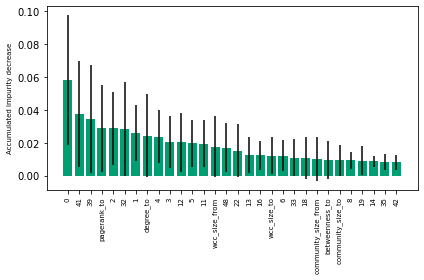

In [59]:
# This code is also included as a method in the RF class

LIMIT=30
font = {"size": 7}
all_cols = np.array(rfe2.X_train_list[0].columns)
importances = rfe2_model.feature_importances_
indices = np.argsort(importances)[::-1][:LIMIT]
std = np.std([tree.feature_importances_ for tree in rfe2_model.estimators_], axis=0)
plt.bar(
    range(all_cols[:LIMIT].shape[0]), importances[indices[:LIMIT]], yerr=std[indices[:LIMIT]],
    align='center', color="#009e73"
)
ax=plt.gca()
plt.xticks(
    range(all_cols[:LIMIT].shape[0]), all_cols[indices[:LIMIT]],
    rotation=90, **font
)
plt.ylabel("Accumulated impurity decrease", **font)
plt.tight_layout()
if not os.path.exists("../reports/figures/"):
    os.mkdir("../reports/figures/")
plt.savefig(f"../reports/figures/elliptic_graph_feat_imp.pdf", bbox_inches="tight")
plt.show()